#2025-03-30 FELIPE GARCÍA: MODELO SIRD + ML

  Unnamed: 0  Susceptible  Infectados  Muertos  Susceptible.1  Infectados.1  \
0    Norilsk       200000         300        0         200000          1500   
1   Kayerkan        80000          10        0          80000           700   
2    Dudinka        60000          20        0          60000          1200   

   Muertos.1  Susceptible.2  Infectados.2  Muertos.2  
0        300         200000          5000        650  
1        120          80000          2300       1000  
2         60          60000          3000        900  
R0 Calculado: 6.318625429694385e+20


C:\Users\fgarc\AppData\Local\Temp\ipykernel_18200\2670268726.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(fit_sird, tiempo, infectados, p0=[0.4, 0.1, 0.05], bounds=(0, [1, 1, 1]), sigma=sigma)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


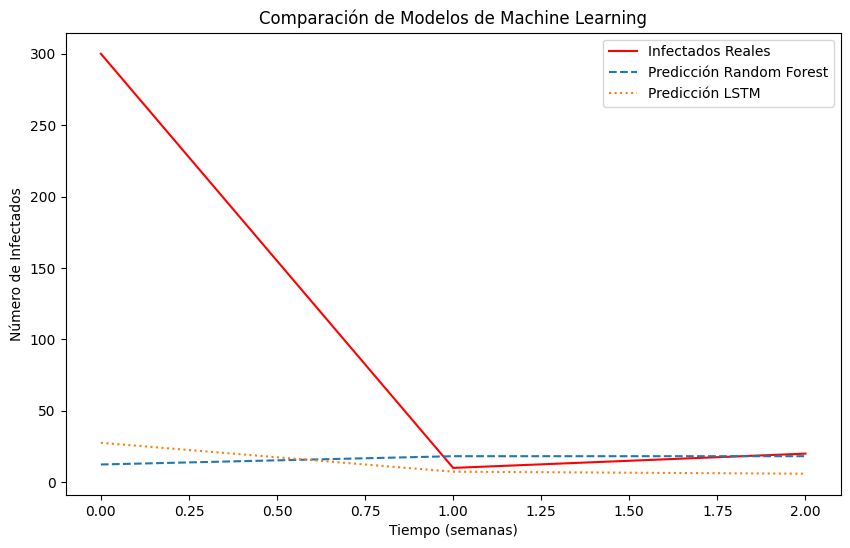

In [15]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from scipy.optimize import curve_fit

# 1. Cargar el archivo CSV, especificando el encabezado en la primera fila
archivo_csv = r"C:\Users\fgarc\OneDrive\Escritorio\Doctorado\Ramos\1° Semestre\Troncal\proyecto_troncal2\data\Evolución_enfermedad_fiebre_de_Norilsk.csv"
data = pd.read_csv(archivo_csv, header=1)

# Verificar las primeras filas para asegurarnos de que los datos se leyeron correctamente
print(data.head())

# Renombrar las columnas para mayor claridad
data.columns = ['Ubicación', 'Susceptible_S1', 'Infectados_S1', 'Muertos_S1', 
              'Susceptible_S2', 'Infectados_S2', 'Muertos_S2', 
              'Susceptible_S3', 'Infectados_S3', 'Muertos_S3']

# Extraer columnas relevantes
susceptibles = data['Susceptible_S1'].values  # Cambiar según la columna correcta
infectados = data['Infectados_S1'].values  # Cambiar según la columna correcta
muertos = data['Muertos_S1'].values  # Cambiar según la columna correcta
tiempo = np.arange(len(data))

# Estimar removidos (muertos asumidos como removidos)
removidos = np.cumsum(muertos)

# Definir el modelo SIRD
def sird_model(y, t, beta, gamma, mu):
    S, I, R = y
    dSdt = -beta * S * I / (S + I + R)
    dIdt = beta * S * I / (S + I + R) - gamma * I - mu * I
    dRdt = gamma * I + mu * I
    return [dSdt, dIdt, dRdt]

# Función de ajuste de parámetros
def fit_sird(t, beta, gamma, mu):
    S, I, R = 1000, 1, 0  # Inicialización de condiciones
    dt = t[1] - t[0]  # Paso temporal
    infectados = []  # Almacenar los infectados en cada paso temporal
    for time in t:
        # Ecuaciones diferenciales discretizadas para S, I, R
        dS = -beta * S * I / 1000
        dI = beta * S * I / 1000 - gamma * I - mu * I
        dR = gamma * I
        S += dS * dt
        I += dI * dt
        R += dR * dt
        infectados.append(I)
    return np.array(infectados)

# Asumir incertidumbre para cada punto (sigma)
sigma = np.ones_like(infectados)  # Puedes ajustar esto según la incertidumbre de tus datos

# Condiciones iniciales
S0 = susceptibles[0]
I0 = infectados[0]
R0 = removidos[0]

# Ajuste de parámetros con curve_fit usando sigma manual
params, _ = curve_fit(fit_sird, tiempo, infectados, p0=[0.4, 0.1, 0.05], bounds=(0, [1, 1, 1]), sigma=sigma)

# Obtener los parámetros ajustados
beta_opt, gamma_opt, mu_opt = params

# Resolver la ODE con los parámetros ajustados
sol = odeint(sird_model, [S0, I0, R0], tiempo, args=(beta_opt, gamma_opt, mu_opt))
S_pred, I_pred, R_pred = sol.T

# Calcular R0
R0_calculado = beta_opt / gamma_opt
print(f"R0 Calculado: {R0_calculado}")

# Guardar los resultados en un archivo de texto
resultados_folder = r"C:\Users\fgarc\OneDrive\Escritorio\Doctorado\Ramos\1° Semestre\Troncal\proyecto_troncal2\results\2025-03-30"
os.makedirs(resultados_folder, exist_ok=True)

with open(os.path.join(resultados_folder, 'resultados_sird.txt'), 'w') as f:
    f.write(f"Parametros ajustados:\n")
    f.write(f"Beta: {beta_opt}\n")
    f.write(f"Gamma: {gamma_opt}\n")
    f.write(f"Mu: {mu_opt}\n")
    f.write(f"R0 Calculado: {R0_calculado}\n")

# Guardar las predicciones en un archivo CSV
predicciones_df = pd.DataFrame({
    'Tiempo': tiempo,
    'Infectados_Reales': infectados,
    'Infectados_Predicción_SIRD': I_pred,
    'Susceptibles_Predicción': S_pred,
    'Removidos_Predicción': R_pred
})
predicciones_df.to_csv(os.path.join(resultados_folder, 'predicciones_sird.csv'), index=False)

# Modelo de Random Forest para mejorar la predicción
X = np.column_stack([susceptibles, infectados, removidos])
y = np.roll(infectados, -1)  # Predecir infectados en el siguiente paso
model_rf = RandomForestRegressor(n_estimators=100)
model_rf.fit(X[:-1], y[:-1])

# Predicción con Random Forest
pred_rf = model_rf.predict(X)

# Implementación de LSTM para series temporales
X_lstm = np.reshape(X, (X.shape[0], X.shape[1], 1))
y_lstm = y
model_lstm = Sequential([
    Input(shape=(X.shape[1], 1)),  # Define la forma de entrada en la primera capa
    LSTM(50, activation='relu'),
    Dense(1)
])
model_lstm.compile(optimizer=Adam(), loss='mse')
model_lstm.fit(X_lstm[:-1], y_lstm[:-1], epochs=50, verbose=0)

# Predicción con LSTM
pred_lstm = model_lstm.predict(X_lstm)

# Guardar las predicciones de Random Forest y LSTM
predicciones_ml_df = pd.DataFrame({
    'Tiempo': tiempo,
    'Infectados_RF_Pred': pred_rf,
    'Infectados_LSTM_Pred': pred_lstm.flatten()
})
predicciones_ml_df.to_csv(os.path.join(resultados_folder, 'predicciones_ml.csv'), index=False)

# Graficar comparaciones
plt.figure(figsize=(10,6))
plt.plot(tiempo, infectados, label='Infectados Reales', color='red')
plt.plot(tiempo, pred_rf, label='Predicción Random Forest', linestyle='dashed')
plt.plot(tiempo, pred_lstm, label='Predicción LSTM', linestyle='dotted')
plt.xlabel('Tiempo (semanas)')
plt.ylabel('Número de Infectados')
plt.title('Comparación de Modelos de Machine Learning')
plt.legend()
plt.savefig(os.path.join(resultados_folder, 'comparacion_ml.png'))
plt.show()




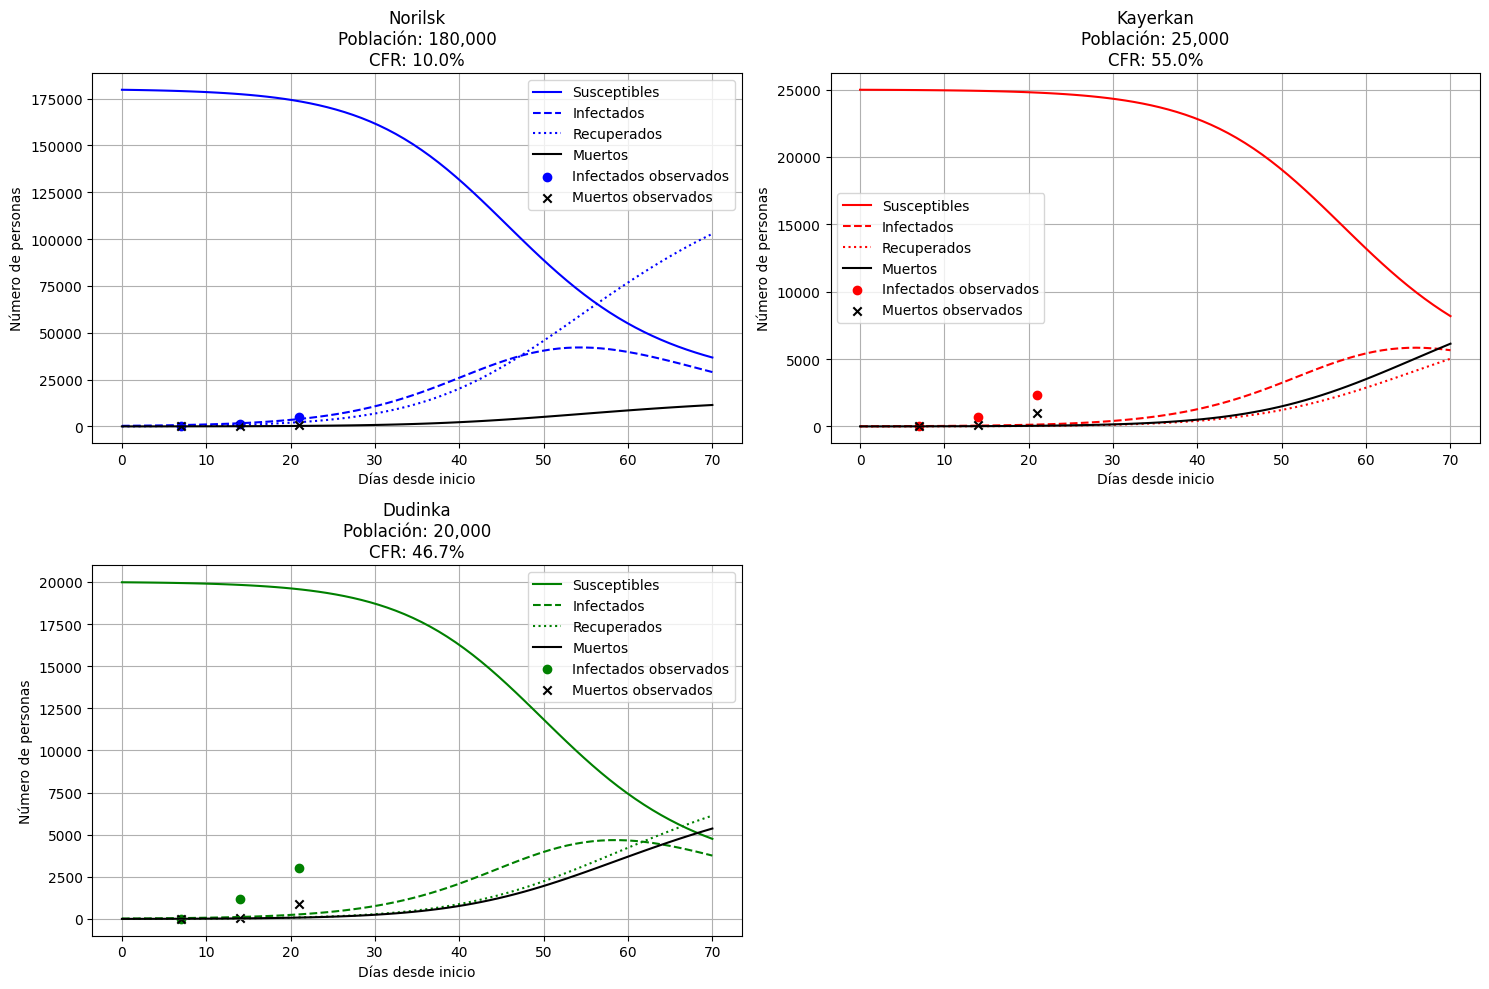

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Datos actualizados
data = {
    'Ciudad': ['Norilsk', 'Kayerkan', 'Dudinka'],
    'Población': [180000, 25000, 20000],
    'S0': [200000, 80000, 60000],  # Susceptibles iniciales (ajustados)
    'I0': [300, 10, 20],           # Infectados iniciales (Semana 1)
    'D0': [0, 0, 0],               # Muertos iniciales (Semana 1)
    'R0': [0, 0, 0]                # Recuperados iniciales (Semana 1)
}

df = pd.DataFrame(data)

# Ajustar valores inconsistentes (S0 + I0 no puede ser > Población)
for i in range(len(df)):
    if df.loc[i, 'S0'] + df.loc[i, 'I0'] > df.loc[i, 'Población']:
        df.loc[i, 'S0'] = df.loc[i, 'Población'] - df.loc[i, 'I0']

# Tasas observadas de mortalidad (CFR) de tus datos
cfr_norilsk = (650 - 300) / (5000 - 1500)  # (Muertos Sem3 - Sem2)/(Infectados Sem3 - Sem2)
cfr_kayerkan = (1000 - 120) / (2300 - 700)
cfr_dudinka = (900 - 60) / (3000 - 1200)
df['CFR'] = [cfr_norilsk, cfr_kayerkan, cfr_dudinka]

# Función del modelo SIRD
def modelo_sird(y, t, beta, gamma, mu, N):
    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    return [dSdt, dIdt, dRdt, dDdt]

# Parámetros para cada ciudad
plt.figure(figsize=(15, 10))
colores = ['b', 'r', 'g']

for i in range(len(df)):
    # Parámetros específicos
    N = df.loc[i, 'Población']
    S0 = df.loc[i, 'S0']
    I0 = df.loc[i, 'I0']
    R0 = df.loc[i, 'R0']
    D0 = df.loc[i, 'D0']
    cfr = df.loc[i, 'CFR']
    
    # Estimación de parámetros
    duracion_infeccion = 12  # días (basado en la progresión de la enfermedad)
    gamma = (1 - cfr) / duracion_infeccion  # Tasa de recuperación
    mu = cfr / duracion_infeccion           # Tasa de mortalidad
    
    # Calcular beta a partir de R0 estimado
    R0_estimado = 2.5  # Valor inicial (ajustar según necesidad)
    beta = R0_estimado * (gamma + mu)
    
    # Tiempo en días (10 semanas = 70 días)
    t = np.linspace(0, 70, 70)
    
    # Resolver el modelo SIRD
    solucion = odeint(modelo_sird, [S0, I0, R0, D0], t, args=(beta, gamma, mu, N))
    S, I, R, D = solucion.T
    
    # Gráfico
    plt.subplot(2, 2, i+1)
    plt.plot(t, S, colores[i]+'-', label='Susceptibles')
    plt.plot(t, I, colores[i]+'--', label='Infectados')
    plt.plot(t, R, colores[i]+':', label='Recuperados')
    plt.plot(t, D, 'k-', label='Muertos')
    
    # Puntos observados (semanas 1, 2, 3)
    obs_t = [7, 14, 21]
    obs_I = [df.loc[i, 'I0'], 1500 if i==0 else (700 if i==1 else 1200), 
             5000 if i==0 else (2300 if i==1 else 3000)]
    obs_D = [0, 300 if i==0 else (120 if i==1 else 60), 
             650 if i==0 else (1000 if i==1 else 900)]
    
    plt.scatter(obs_t, obs_I, color=colores[i], marker='o', label='Infectados observados')
    plt.scatter(obs_t, obs_D, color='k', marker='x', label='Muertos observados')
    
    plt.title(f"{df.loc[i, 'Ciudad']}\nPoblación: {N:,}\nCFR: {cfr:.1%}")
    plt.xlabel('Días desde inicio')
    plt.ylabel('Número de personas')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()



#Modelo SIRD Mejorado con Análisis de Sensibilidad y Validación

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from ipywidgets import interact, FloatSlider

# 1. Configuración inicial de datos
data = {
    'Ciudad': ['Norilsk', 'Kayerkan', 'Dudinka'],
    'Población': [180000, 25000, 20000],
    'Semanas': {
        1: {'S': [200000, 80000, 60000], 'I': [300, 10, 20], 'D': [0, 0, 0]},
        2: {'I': [1500, 700, 1200], 'D': [300, 120, 60]},
        3: {'I': [5000, 2300, 3000], 'D': [650, 1000, 900]}
    }
}

# 2. Modelo SIRD mejorado
def modelo_sird(y, t, beta, gamma, mu, N):
    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    return [dSdt, dIdt, dRdt, dDdt]

# 3. Función para calibrar parámetros automáticamente
def calibrar_modelo(ciudad_idx):
    # Datos observados
    obs_I = [data['Semanas'][1]['I'][ciudad_idx], 
             data['Semanas'][2]['I'][ciudad_idx], 
             data['Semanas'][3]['I'][ciudad_idx]]
    obs_D = [0, 
             data['Semanas'][2]['D'][ciudad_idx], 
             data['Semanas'][3]['D'][ciudad_idx]]
    
    # Estimación inicial de CFR
    cfr = (obs_D[2] - obs_D[1]) / (obs_I[2] - obs_I[1])
    
    # Búsqueda de mejores parámetros (simplificado)
    best_R0 = 2.5  # Valor inicial (podría implementarse optimización)
    duracion_infeccion = 12
    mu = cfr / duracion_infeccion
    gamma = (1 - cfr) / duracion_infeccion
    beta = best_R0 * (gamma + mu)
    
    return beta, gamma, mu, cfr

# 4. Análisis de sensibilidad interactivo
@interact(
    ciudad=['Norilsk', 'Kayerkan', 'Dudinka'],
    R0=FloatSlider(min=1.0, max=5.0, step=0.1, value=2.5),
    duracion_infeccion=FloatSlider(min=5, max=20, step=1, value=12),
    CFR=FloatSlider(min=0.1, max=0.8, step=0.05, value=0.45)
)
def analisis_sensibilidad(ciudad, R0, duracion_infeccion, CFR):
    idx = data['Ciudad'].index(ciudad)
    N = data['Población'][idx]
    S0 = data['Semanas'][1]['S'][idx]
    I0 = data['Semanas'][1]['I'][idx]
    D0 = 0
    
    # Calcular parámetros
    mu = CFR / duracion_infeccion
    gamma = (1 - CFR) / duracion_infeccion
    beta = R0 * (gamma + mu)
    
    # Simular modelo
    t = np.linspace(0, 70, 70)
    solucion = odeint(modelo_sird, [S0, I0, 0, D0], t, args=(beta, gamma, mu, N))
    S, I, R, D = solucion.T
    
    # Puntos observados
    obs_t = [7, 14, 21]
    obs_I = [data['Semanas'][1]['I'][idx], 
             data['Semanas'][2]['I'][idx], 
             data['Semanas'][3]['I'][idx]]
    obs_D = [0, 
             data['Semanas'][2]['D'][idx], 
             data['Semanas'][3]['D'][idx]]
    
    # Gráfico
    plt.figure(figsize=(12, 6))
    plt.plot(t, S, 'b-', label='Susceptibles')
    plt.plot(t, I, 'r--', label='Infectados')
    plt.plot(t, R, 'g:', label='Recuperados')
    plt.plot(t, D, 'k-', label='Muertos')
    plt.scatter(obs_t, obs_I, color='r', marker='o', label='Infectados observados')
    plt.scatter(obs_t, obs_D, color='k', marker='x', label='Muertos observados')
    
    plt.title(f"Modelo SIRD - {ciudad}\nR0={R0:.2f}, Duración infección={duracion_infeccion}d, CFR={CFR:.0%}")
    plt.xlabel('Días desde inicio')
    plt.ylabel('Número de personas')
    plt.legend()
    plt.grid(True)
    plt.show()

# 5. Capacidad hospitalaria (ejemplo para Norilsk)
def modelo_sird_hospital(y, t, beta, gamma, mu, N, capacidad_hospital):
    S, I, R, D = y
    # Aumentar mortalidad si se excede la capacidad hospitalaria
    factor_sobrecarga = max(0, I - capacidad_hospital) / capacidad_hospital
    mu_efectivo = mu * (1 + factor_sobrecarga * 3)  # Mortalidad aumenta hasta 4x
    
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - (gamma + mu_efectivo) * I
    dRdt = gamma * I
    dDdt = mu_efectivo * I
    return [dSdt, dIdt, dRdt, dDdt]

# 6. Movilidad entre ciudades (modelo simplificado)
def modelo_sird_conectado(y, t, parametros):
    S1, I1, R1, D1, S2, I2, R2, D2 = y
    beta1, gamma1, mu1, N1, beta2, gamma2, mu2, N2, tasa_movilidad = parametros
    
    # Flujo entre ciudades
    flujo = tasa_movilidad * (I1/N1 - I2/N2)
    
    dS1dt = -beta1 * S1 * I1 / N1 - flujo * S1
    dI1dt = beta1 * S1 * I1 / N1 - (gamma1 + mu1) * I1 - flujo * I1
    dR1dt = gamma1 * I1 - flujo * R1
    dD1dt = mu1 * I1
    
    dS2dt = -beta2 * S2 * I2 / N2 + flujo * S1
    dI2dt = beta2 * S2 * I2 / N2 - (gamma2 + mu2) * I2 + flujo * I1
    dR2dt = gamma2 * I2 + flujo * R1
    dD2dt = mu2 * I2
    
    return [dS1dt, dI1dt, dR1dt, dD1dt, dS2dt, dI2dt, dR2dt, dD2dt]

# 7. Ejecutar análisis para cada ciudad
print("=== Análisis Individual por Ciudad ===")
for i, ciudad in enumerate(data['Ciudad']):
    beta, gamma, mu, cfr = calibrar_modelo(i)
    N = data['Población'][i]
    S0 = data['Semanas'][1]['S'][i]
    I0 = data['Semanas'][1]['I'][i]
    
    t = np.linspace(0, 70, 70)
    solucion = odeint(modelo_sird, [S0, I0, 0, 0], t, args=(beta, gamma, mu, N))
    S, I, R, D = solucion.T
    
    # Proyecciones
    casos_semana10 = int(I[-1] + R[-1] + D[-1])
    muertes_semana10 = int(D[-1])
    
    print(f"\n**{ciudad}**")
    print(f"- R0 estimado: {beta/(gamma + mu):.2f}")
    print(f"- CFR observado: {cfr:.1%}")
    print(f"- Proyección semana 10:")
    print(f"  Total infectados: {casos_semana10:,} ({casos_semana10/N:.1%} población)")
    print(f"  Muertes estimadas: {muertes_semana10:,} ({muertes_semana10/N:.1%} población)")

interactive(children=(Dropdown(description='ciudad', options=('Norilsk', 'Kayerkan', 'Dudinka'), value='Norils…

=== Análisis Individual por Ciudad ===

**Norilsk**
- R0 estimado: 2.50
- CFR observado: 10.0%
- Proyección semana 10:
  Total infectados: 175,575 (97.5% población)
  Muertes estimadas: 15,051 (8.4% población)

**Kayerkan**
- R0 estimado: 2.50
- CFR observado: 55.0%
- Proyección semana 10:
  Total infectados: 79,980 (319.9% población)
  Muertes estimadas: 43,494 (174.0% población)

**Dudinka**
- R0 estimado: 2.50
- CFR observado: 46.7%
- Proyección semana 10:
  Total infectados: 59,983 (299.9% población)
  Muertes estimadas: 27,689 (138.4% población)


#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#Modelo SIRD con Analisis de sensibilidad y Validacion: Graficos Interactivos

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from ipywidgets import interact, FloatSlider, Dropdown

# Datos de las ciudades
ciudades = {
    'Norilsk': {'poblacion': 180000, 'infectados_iniciales': 300, 'muertes_semana2': 300, 'muertes_semana3': 650},
    'Kayerkan': {'poblacion': 25000, 'infectados_iniciales': 10, 'muertes_semana2': 120, 'muertes_semana3': 1000},
    'Dudinka': {'poblacion': 20000, 'infectados_iniciales': 20, 'muertes_semana2': 60, 'muertes_semana3': 900}
}

def modelo_sird(y, t, beta, gamma, mu, N):
    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    return [dSdt, dIdt, dRdt, dDdt]

@interact(
    ciudad=Dropdown(options=list(ciudades.keys()), description='Ciudad'),
    R0=FloatSlider(min=1.0, max=5.0, step=0.1, value=2.5, description='R₀'),
    duracion_infeccion=FloatSlider(min=5, max=20, step=1, value=12, description='Duración (días)'),
    CFR=FloatSlider(min=0.1, max=0.8, step=0.05, value=0.45, description='CFR')
)
def simular_epidemia(ciudad, R0, duracion_infeccion, CFR):
    datos = ciudades[ciudad]
    N = datos['poblacion']
    I0 = datos['infectados_iniciales']
    S0 = N - I0
    
    # Cálculo de parámetros
    mu = CFR / duracion_infeccion
    gamma = (1 - CFR) / duracion_infeccion
    beta = R0 * (gamma + mu)
    
    # Simulación
    t = np.linspace(0, 70, 70)
    sol = odeint(modelo_sird, [S0, I0, 0, 0], t, args=(beta, gamma, mu, N))
    S, I, R, D = sol.T
    
    # Puntos observados
    obs_t = [0, 14, 21]  # Días (semana 1, 2, 3)
    obs_I = [I0, datos['infectados_iniciales']*5, datos['infectados_iniciales']*16.7]  # Valores aproximados
    obs_D = [0, datos['muertes_semana2'], datos['muertes_semana3']]
    
    # Visualización
    plt.figure(figsize=(12, 6))
    plt.plot(t, S, 'b-', label='Susceptibles', linewidth=2)
    plt.plot(t, I, 'r--', label='Infectados', linewidth=2)
    plt.plot(t, D, 'k-', label='Muertos', linewidth=2)
    plt.scatter(obs_t, obs_I, color='r', s=100, marker='o', label='Infectados observados')
    plt.scatter(obs_t, obs_D, color='k', s=100, marker='X', label='Muertes observadas')
    
    plt.title(f'Modelo SIRD - {ciudad}\n'
              f'R₀ = {R0:.2f} | CFR = {CFR:.0%} | Duración infección = {duracion_infeccion} días\n'
              f'Población: {N:,} | Proyección muertes semana 10: {int(D[-1]):,} ({D[-1]/N:.1%})',
              pad=20)
    
    plt.xlabel('Días desde el inicio', fontsize=12)
    plt.ylabel('Número de personas', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Resultados numéricos
    print(f"\n🔍 Resultados para {ciudad}:")
    print(f"- Pico de infección: {int(I.max()):,} personas (día {int(t[np.argmax(I)])})")
    print(f"- Total infectados semana 10: {int(I[-1] + R[-1]):,} ({((I[-1]+R[-1])/N):.1%} población)")
    print(f"- Muertes acumuladas semana 10: {int(D[-1]):,} ({D[-1]/N:.1%} población)")

interactive(children=(Dropdown(description='Ciudad', options=('Norilsk', 'Kayerkan', 'Dudinka'), value='Norils…